# Representations, Kynematics and Dynamics

Duckietown exercises for Sept 16th, 2019



## 1. Frame manipulation

It's emergency time in Duckietown! An earthquack shook the quiet village, and some buildings have fallen on the streets!

You are the head of operations, and you gave to your Duckiebot a critical recognition mission: identify and place road obstacles on the map.

During its mission, your Duckiebot has GPS support, and it knows its own position in the global (map) frame. 

It encounters its first obstacle when at position  x = 2m and y = 0.4m, and orientation theta = 110 degrees.
The obstacle itself is at 30 cm at 30 degrees (anti-clockwise) from the Duckiebot. 

Where on the map frame should obstacle 1 be placed?


In [1]:
import numpy as np

duckie_pos_g = np.array([2, 0.4])   # Position of Duckiebot in global frame
duckie_or_g = 110                   # Orientation of Duckiebot in global frame (degrees)
obstacle_dist_to_duckie = 0.3       # Obstacle distance to the Duckiebot
obstacle_angle = 30                 # Obstacle angle with respect to Duckiebot

###

# Calculations here

###

obstacle_pos_g = np.array([0, 0])    # Put your answer here instead of 0, 0 (position of obstacle in global frame)


A concerned Duckie citizen calls you: 

`I can see a piece of roof on the road! It's positioned at x = 4m and y = - 1m!`

This is valuable information but, to add it to your map, you need your Duckiebot to verify it. Luckily, your Duckiebot is closeby, at x = 3.5m, y = -1.2m, and oriented at theta = 45 degrees.
You need to give a waypoint to your Duckiebot in its robot frame so that it can go and look.

In the robot frame, what are the cartesian coordinates of the obstacle described by the concerned Duckie citizen?

In [ ]:
duckie_pos_g = np.array([3.5, -1.2])   # Position of Duckiebot in global frame
duckie_or_g = 45                       # Orientation of Duckiebot in global frame (degrees)
obstacle_pos_g = np.array([4, -1])     # Position of obstacle in global frame

###

# Calculations here

###

obstacle_pos_r = np.array([0, 0])     # Put your answer here (position of obstacle in global frame)


## 2. Driving

Good job! All the obstacles have been detected and mapped. Now, it's time for phase 2: acting.
Before anything, please run the cell below to get stuff working.

In [138]:
# Some stuff to get the demo working.
# No need to read!
# Actually reading this could be cheating :P

# Graciously inspired from the hard work of @maximecb and @bhairavMmehta95. 


import math
import numpy as np
import matplotlib.pyplot as plt

def plot_poses(poses, goal = False, draw_line=False):
    coords = np.array([p[0] for p in poses])
    xmin = np.min(coords[:, 0])
    xmax = np.max(coords[:, 0])
    ymin = np.min(coords[:, 1])
    ymax = np.max(coords[:, 1])
    
    if goal:
        xmin = np.minimum(xmin, goal[0])
        xmax = np.maximum(xmax, goal[0])
        ymin = np.minimum(ymin, goal[1])
        ymax = np.maximum(ymax, goal[1])

    plt.axis([xmin - 0.1, xmax + 0.1, ymin - 0.1, ymax + 0.1])
    for i, p in enumerate(poses):
        x = p[0][0]
        y = p[0][1]
        arrow_angle = math.radians(p[1])
        
        if i == len(poses) -1:
            plt.arrow(x, y, 0.001 * math.cos(arrow_angle), 0.001 * math.sin(arrow_angle),
                 head_width=0.1, head_length=0.16,
                  fc='r', ec='r')
        else:
            plt.arrow(x, y, 0.001 * math.cos(arrow_angle), 0.001 * math.sin(arrow_angle),
                 head_width=0.1, head_length=0.16,
                  fc='k', ec='k')
            
    if goal:
        plt.arrow(goal[0], goal[1], 0.001 * math.cos(math.radians(goal[2])), 0.001 * math.sin(math.radians(goal[2])), head_width=0.1, head_length=0.16,
                  fc='g', ec='g')
        final_pose = poses[-1]
        if math.fabs(final_pose[0][0] - goal[0]) < 0.01 and math.fabs(final_pose[0][1] - goal[1]) < 0.01 and math.fabs(final_pose[1] - goal[2]) < 0.1:
            print("Goal achieved! Great job!")
            
    if draw_line:
        plt.hlines(0, 0, xmax, linestyles='dashed', colors='r')


def rotate_point(px, py, cx, cy, theta):
    """
    Rotate a 2D point around a center
    """

    dx = px - cx
    dy = py - cy

    new_dx = dx * math.cos(theta) - dy * math.sin(theta)
    new_dy = dy * math.cos(theta) + dx * math.sin(theta)

    return cx + new_dx, cy + new_dy
  
def get_dir_vec(angle):
    """
    Vector pointing in the direction the agent is looking (angle in degrees)
    """
    dir_angle = math.radians(angle)
    x = math.cos(dir_angle)
    y = math.sin(dir_angle)
    return np.array([x, y])

def get_right_vec(angle):
    """
    Vector pointing to the right of the agent (angle in degrees)
    """
    dir_angle = math.radians(angle)

    x = math.sin(dir_angle)
    y = -math.cos(dir_angle)
    return np.array([x, y])

def drive(cur_pos, cur_angle):
    """
    Drive this bad boy
    """
    cur_pos = np.array(cur_pos)
    
    Vl = left_rate * wheel_radius * np.pi * 2
    Vr = right_rate * wheel_radius * np.pi * 2 # rate is in turns/sec
    l = wheel_dist

    # If the wheel velocities are the same, then there is no rotation
    if Vl == Vr:
      cur_pos = cur_pos + dt * Vl * get_dir_vec(cur_angle)
      return cur_pos, cur_angle

    # Compute the angular rotation velocity about the ICC (center of curvature)
    w = (Vr - Vl) / l
    # Compute the velocity
    v = (Vl + Vr) / 2
    

    # Compute the distance to the center of curvature
    r = v/w

    # Compute the rotation angle for this time step
    rotAngle = w * dt

    # Rotate the robot's position around the center of rotation
    r_vec = -get_right_vec(cur_angle)
    px, py = cur_pos
    cx = px + r * r_vec[0]
    cy = py + r * r_vec[1]
    npx, npy = rotate_point(px, py, cx, cy, rotAngle)
    next_pos = np.array([npx, npy])
   
    # Update the robot's direction angle
    next_angle = cur_angle + math.degrees(rotAngle)
    return next_pos, next_angle

Now that you have run the cell above, you can continue.

In order to remove the obstacles that are paralyzing Duckietown, your Duckiebot is equipped with a very special tool that can lift obstacles, but only if it is used in the right direction.
What's more, the tool allows you to carry several obstacles at the same time - which is efficient. But you can only give one command to the wheels between each of them...

You send your Duckiebot to gather obstacle 1 at x = -3m, y = 2m and theta = 45 degrees. The obstacle 2 is at x = 1m, y = 1m and theta = -45 degrees. 
Knowing that you want to join obstacle 2 exactly 10 seconds after having gathered obstacle 1, which command do you send to the each of the wheels?

Write your values in `left_rate` and `right_rate` to test your answer. If it gets to the green arrow, you win!


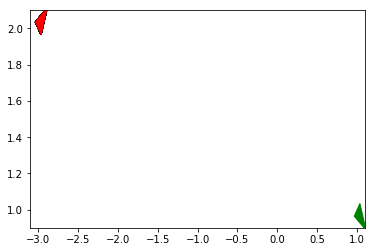

In [143]:
start_pos = [-3, 2]
cur_angle = 45          # angle in degrees
cur_pos = start_pos

wheel_dist = 0.2         # 0.2 meters of distance between the wheels
wheel_radius = 0.03      # radius of the wheels is 0.03 meters (3 cm)

dt = 0.1
total_timesteps = 100


####### Modify here

left_rate = 0        #  in turns per second
right_rate = 0

#######

poses = [(cur_pos, cur_angle)]

for t in range(total_timesteps):
    cur_pos, cur_angle = drive(cur_pos, cur_angle)
    poses.append((cur_pos, cur_angle))
    
    
plot_poses(poses, goal = (1, 1, -45))

## 3. Calibration

That went well!
But that's because the model we used is a simulation and the robot acts exactly as we tell it to act.
In real life... each robot has its own characteristics - for each wheel, the radius and the motor power are slighly different.
So we need to calibrate it.


First, run this code to setup the demo:

In [242]:
def calibrate_drive(cur_pos, cur_angle, gain, trim, dt, seed):
    limit = 1
    l = 0.2                  # 0.2 meters of distance between the wheels
    wheel_radius = 0.03      # radius of the wheels is 0.03 meters (3 cm) as we know it
    
    desired_rate = 1                           # Turns per second
    desired_omega = 2*np.pi * desired_rate     # In radians
    
    desired_omega_r = desired_omega
    desired_omega_l = desired_omega
       
    
    k = 27                                     # Motor constant as we know it
    
    k_r_inv = (gain + trim) / k                # Inverse motor constant after trim
    k_l_inv = (gain - trim) / k                
    
    
    # conversion from motor rotation rate to duty cycle, according to what we know
    u_r = desired_omega_r * k_r_inv
    u_l = desired_omega_l * k_l_inv
    
    # limiting output to limit, which is 1.0 for the duckiebot
    u_r_limited = max(min(u_r, limit), -limit)
    u_l_limited = max(min(u_l, limit), -limit)
    
    # Modelling the real values of radius and motor constants
    np.random.seed(seed)
    radius_r = np.random.uniform(wheel_radius - 0.0015, wheel_radius + 0.0015)
    radius_l = np.random.uniform(wheel_radius - 0.0015, wheel_radius + 0.0015)
    k_l_noisy = np.random.uniform(k - 0.25, k + 0.25)
    k_r_noisy = np.random.uniform(k - 0.25, k + 0.25)

    # Real values of inverse motor constants
    k_r_inv_noisy = 1/k_r_noisy
    k_l_inv_noisy = 1/k_l_noisy

    # Real values of wheel angular velocity
    omega_r_limited = u_r_limited/k_r_inv_noisy
    omega_l_limited = u_l_limited/k_l_inv_noisy
    
    # Real wheel velocities
    Vr = omega_r_limited * radius_r
    Vl = omega_l_limited * radius_l
    

    # If the wheel velocities are the same, then there is no rotation
    if Vl == Vr:
        cur_pos = cur_pos + dt * Vr * get_dir_vec(cur_angle)
        return cur_pos, cur_angle

    
    # Compute the angular rotation velocity about the ICC (center of curvature)
    w = (Vr - Vl) / l
    # Compute the velocity
    v = (Vl + Vr) / 2

    # Compute the distance to the center of curvature
    r = v/w

    # Compute the rotation angle for this time step
    rotAngle = w * dt

    # Rotate the robot's position around the center of rotation
    r_vec = -get_right_vec(cur_angle)
    px, py = cur_pos
    cx = px + r * r_vec[0]
    cy = py + r * r_vec[1]
    npx, npy = rotate_point(px, py, cx, cy, rotAngle)
    next_pos = np.array([npx, npy])
   
    # Update the robot's direction angle
    next_angle = cur_angle + math.degrees(rotAngle)
    
    return next_pos, next_angle

Now: adjust the gain and the trim so that the robot reaches the goal location in green - which is where it would be if the model was perfect.
Exercise is achieved when you get a "Goal achieved! Great job!" appearing on your screen!

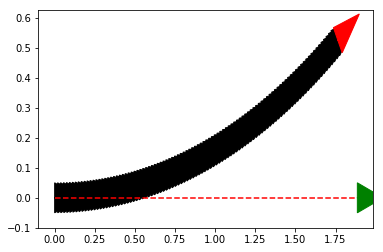

In [243]:
# Pick a number, any number!
seed = 500

# Adjust these!
gain = 1
trim = 0

## From here, do not change

dt = 0.1
total_timesteps = 100

start_pos = [0, 0]
cur_pos = start_pos
cur_angle = 0

poses = [(cur_pos, cur_angle)]

for t in range(total_timesteps):
    cur_pos, cur_angle = calibrate_drive(cur_pos, cur_angle, gain, trim, dt, seed)
    poses.append((cur_pos, cur_angle))
   
plot_poses(poses, goal = (1.885, 0, 0), draw_line=True)